<a href="https://colab.research.google.com/github/farsim-hossain/python-projects/blob/main/Load_and_Preprocess_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load and preprocess images

We will explore some different ways to load and preprocess image data.

In [1]:
import numpy as np
import os 
import PIL #python imaging library
import PIL.Image
import tensorflow as tf 
import tensorflow_datasets as tfds

print(tf.__version__)

2.4.1


## Downloading the flower dataset 

The dataset directory has 5 directories including several photos of flowers

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname = 'flower_photos',
                                   untar = True)

data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

A total of 3670 images are in the dataset directory.

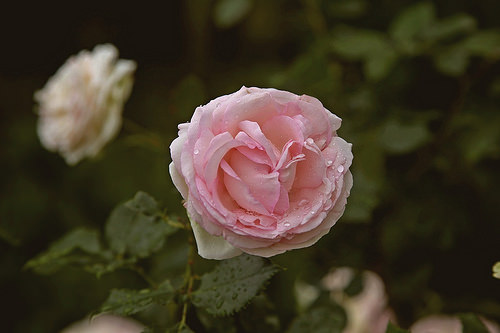

In [4]:
roses = list(data_dir.glob('roses/*')) #opening the roses directory
PIL.Image.open(str(roses[0])) # looking at the first image of the list

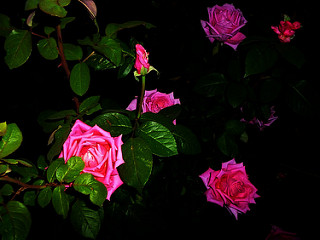

In [5]:
# another one 
PIL.Image.open(str(roses[1]))

## Load using keras.preprocesing

We will use a function to load the images into datasets. => image_dataset_from_directory

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
#80 % data for training

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [15]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height,img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [8]:
# class names 

class_names = train_ds.class_names
class_names


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

## Visualizing the data 

Lets see first few images from the training dataset.

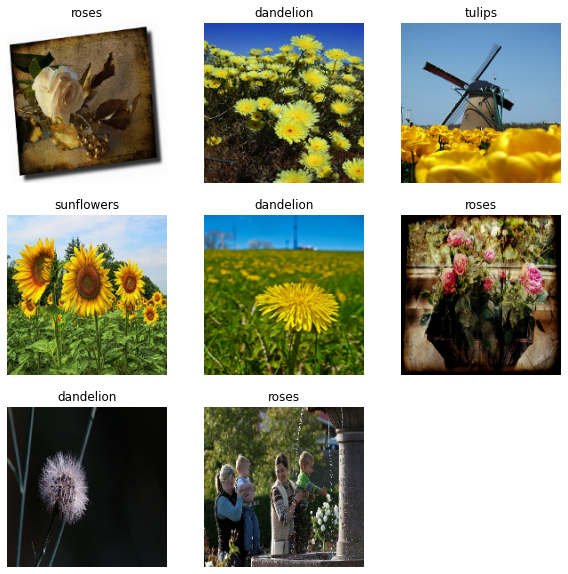

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))

for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Image and label shapes of the training set

There is a way to see the image shapes and label shapes. In the below code, we will see the image_batch shape is a 4 number tensor which will state that there are 32 images, the dimension is 180X180 and the picture is an RGB(3).

In [10]:
for image_batch, label_batch in train_ds:
  print(image_batch.shape)
  print(label_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Standardize the data

We are still playing in very very basic level. There are far more ways to play with the data and make complex modelling that is still beyond our knowledge. 

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer.

In [11]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)


Lets map this to the dataset. and the rgb values will be scaled automatically.

In [12]:
normalized_ds = train_ds.map(lambda x,y : (normalization_layer(x), y))

image_batch,label_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


In the above code, we extracted the first image and showed that the image is scaled between the number 0.0 and 0.9690 

## Configure the dataset for performance 

Well well...here some little data engineering. When working with big volume of data, we have to deal with that so that the process runs smoothly without consuming much resource. One such process is .cache() and .prefetch(). We will apply them here.

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

## Training a model 
We will train the model with the data we preprocessed. 

In [17]:
num_classes = 5 

model = tf.keras.Sequential([
                             layers.experimental.preprocessing.Rescaling(1./255),
                             layers.Conv2D(32,3,activation='relu'),
                             layers.MaxPooling2D(),
                             layers.Conv2D(32,3,activation='relu'),
                             layers.MaxPooling2D(),
                             layers.Conv2D(32,3,activation = 'relu'),
                             layers.MaxPooling2D(),
                             layers.Flatten(),
                             layers.Dense(128, activation = 'relu'),
                             layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer='adam',
              loss = tf.losses.SparseCategoricalCrossentropy(from_logits =True),
              metrics = ['accuracy'])

In [20]:
model.fit(train_ds,validation_data=val_ds,epochs=3)

Epoch 1/3
92/92 [==============================] - 115s 1s/step - loss: 1.4560 - accuracy: 0.3607 - val_loss: 1.0893 - val_accuracy: 0.5599
Epoch 2/3
92/92 [==============================] - 107s 1s/step - loss: 1.0883 - accuracy: 0.5452 - val_loss: 1.0156 - val_accuracy: 0.5872
Epoch 3/3
92/92 [==============================] - 106s 1s/step - loss: 0.9231 - accuracy: 0.6490 - val_loss: 0.9948 - val_accuracy: 0.6131


## Using another way to extrach data from the image directory 

The above keras.preprocessing utilities are a convenient way to create a tf.data.Dataset from a directory of images. For finer grain control, you can write your own input pipeline using tf.data. This section shows how to do just that, beginning with the file paths from the zip we downloaded earlier.

In [21]:
#shuffling 

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle =False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration =False)

for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/daisy/4229503616_9b8a42123c_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/4624036600_11a4744254_n.jpg'
b'/root/.keras/datasets/flower_photos/roses/537625768_791e973b40.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/14728922673_99086a3818_n.jpg'
b'/root/.keras/datasets/flower_photos/daisy/695778683_890c46ebac.jpg'


In [23]:
# getting the class names

class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name!= 'LICENSE.txt']))
class_names

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

In [24]:
# split the dataset 
val_size = int(image_count*0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())


2936
734


In [29]:
## again preprocessing in a different way , the whole point of the below code is to get the path and return the image with their labels

def get_label(file_path):
  #convert the path to a list of path components 
  parts = tf.strings.split(file_path, os.path.sep)
  # the second to last is the class-directory
  one_hot = parts[-2]==class_names
  # integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # convert the compressed strinf to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels =3)

  #resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

# GET IT ! 

In [30]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  4


## Configure dataset for performance
To train a model with this dataset you will want the data:

To be well shuffled.
To be batched.
Batches to be available as soon as possible.

In [31]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size = 1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size = AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## New Model with new preprocessing

In [32]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs =3
)

Epoch 1/3
92/92 [==============================] - 117s 1s/step - loss: 0.8024 - accuracy: 0.7016 - val_loss: 0.7720 - val_accuracy: 0.7084
Epoch 2/3
92/92 [==============================] - 109s 1s/step - loss: 0.6268 - accuracy: 0.7626 - val_loss: 0.8285 - val_accuracy: 0.7016
Epoch 3/3
92/92 [==============================] - 109s 1s/step - loss: 0.4714 - accuracy: 0.8256 - val_loss: 0.7863 - val_accuracy: 0.7275


## We can also load the data using tensorflow datasets


In [35]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info = True,
    as_supervised = True
)

num_classes = metadata.features['label'].num_classes
num_classes

5

## Get image from the dataset

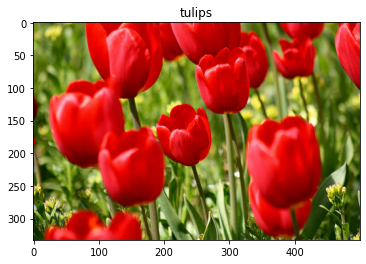

In [41]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_=plt.imshow(image)
_=plt.title(get_label_name(label))

We will batch , shuffle and configure each dataset for performance 


In [42]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)